# Spectroscopy and Embeddings for Undirected Graphs

### Simon R Schneider, 2018

## Theory

The Laplacian matrix of a graph is a discrete analogue of the continuous Laplacian operator (in Euclidean and other spaces), which provides a scalar measure how much a function varies locally about each point. It's useful, for example, for studying dissipation through a graph. Equally fun, however, is to study its second-order analogue: standing waves on the graph. Formally, we solve the wave equation apadted to discrete space (immediately below). In solving, we associate with each Laplacian eigenvalue $l$ and eigenvector $\vec{v}$ the wavelength $\lambda$ of the corresponding standing wave.

${{d^2} \over {{dt}^2}} \vec{x}(t) = -c^2 L \ \vec{x}(t)$

Note that time-oscillating eigenvectors of the Laplacian solve the differential equation.

$\vec{x}(t) = e^{2 \pi i f t} \ \vec{v}$

This gives frequency as $2 \pi f = c \sqrt{l}$. Recall the linear relationship between wave speed, frequency, and wavelength ($c = f \lambda$) to eliminate $c$ and $f$ and find

$\lambda = {{2 \pi} \over \sqrt{l}}$

Wavelengths are interprettable as the longest chain you could traverse on the graph before seeing the components of the eigenvector go from fully positive to fully negative and back again (or vice versa). The longest wavelengths are comparable to the diameter of the graph. This characterization of the eigenvectors makes for a nice criterion when selecting spectral components for embeddings, visualization, clusting, etc....

## Demo

Let's build three synthetic graphs, one of which is planar and almost boring, the second of which has clusters, and the third of which has biclusters. We'll look at each's structure by way of this spectral interpretation.

In [1]:
import random
import numpy as np
import scipy.linalg as la

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from pylab import rcParams, subplots

In [2]:
rcParams['figure.figsize'] = (30, 10)
random.seed(42)

In [3]:
def compute_undirected_degrees(adjacency_matrix):
    sum_row = lambda v: v.sum()
    return np.apply_along_axis(sum_row, 0, adjacency_matrix)


def compute_undirected_laplacian(adjacency_matrix):
    degrees = compute_undirected_degrees(adjacency_matrix)
    return np.diag(degrees) - adjacency_matrix


def fraction_of_edges_explained(adjacency_matrix, clusters):
    # total edges in the graph
    total_edges = adjacency_matrix.sum() / 2
    # edges between vertices in same cluster
    intra_edges = 0
    for c in np.unique(clusters):
        which = clusters == c
        addl_intra_edges = adjacency_matrix[which][:, which].sum() / 2
        intra_edges += addl_intra_edges
    return intra_edges / total_edges


def plot_graph(coordinates, adjacency_matrix,
               colors='black', edges=0.2, title = ''):

    x = coordinates[:, 0]
    y = coordinates[:, 1]

    if edges:
        line_coords = [
            [(x[ind_0], y[ind_0]), (x[ind_1], y[ind_1])]
            for (ind_0, ind_1) in np.asarray(np.argwhere(adjacency_matrix))
        ]

        lines = LineCollection(
            line_coords, linewidths=0.1, color = np.array([0, 0, 0, edges])
        )

        fig, ax = subplots()
        ax.add_collection(lines)
        ax.autoscale()
        ax.margins(0.1)

    plt.scatter(x, y, s = 40, c = colors, alpha = 0.25)
    plt.title(title)
    plt.show()

### a planar graph with simple structure

We build an n x n planar graph, then make a linear cut at the center of one axis, leaving several conencted vertices in the middle (see visualizations below). Without the linear cut, we would expect the normal modes to be the familiar Fourier modes (max wavelength of 2n (approximately that graph's diameter), with multiplcity two (one for either dimension)). Here, there are both similarities to and recognizable perturbations from the Fourier modes.

In [4]:
n = 50  # an n x n square grid with most of a slice missing
r = 5  # r is the radius of the connection in the middle. 2r + 1 vectices

adj = np.zeros((n ** 2, n ** 2))

# add planar edges
for i in range(n):
    for j in range(n):
        for delta_i in [0, 1]:
            delta_j = 1 - delta_i
            new_i = i + delta_i
            new_j = j + delta_j
            if new_i >= n or new_j >= n:
                # off the grid
                continue
            # else add an edge
            adj[n * i + j, n * new_i + new_j] = 1
            adj[n * new_i + new_j, n * i + j] = 1

# make a linear cut (except for a bit in the middle)
for j in range(n):
    i = int(n / 2)
    if abs(j - int(n / 2)) <= r:
        # near the middle 
        continue
    # else remove an edge
    new_i = i + 1
    new_j = j
    adj[n * i + j, n * new_i + new_j] = 0
    adj[n * new_i + new_j, n * i + j] = 0
    
adj = np.asmatrix(adj)

In [5]:
m = 10
lap = compute_undirected_laplacian(adj)
values, vectors = la.eigh(lap, eigvals=(0, m))

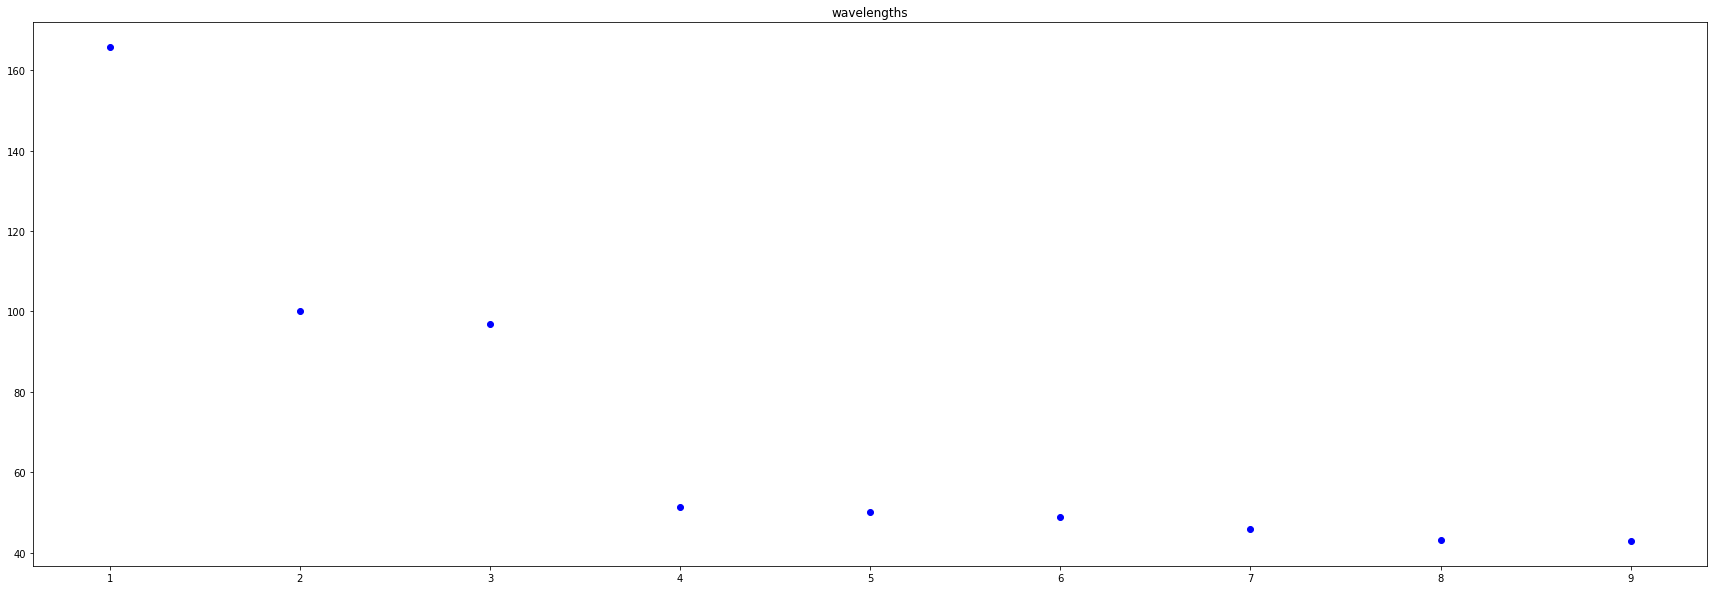

In [6]:
wavelengths = 2 * np.pi * np.reciprocal(np.sqrt(values[1:m]))

plt.scatter(range(1, m), wavelengths, color = 'blue')
plt.title('wavelengths')
plt.show()

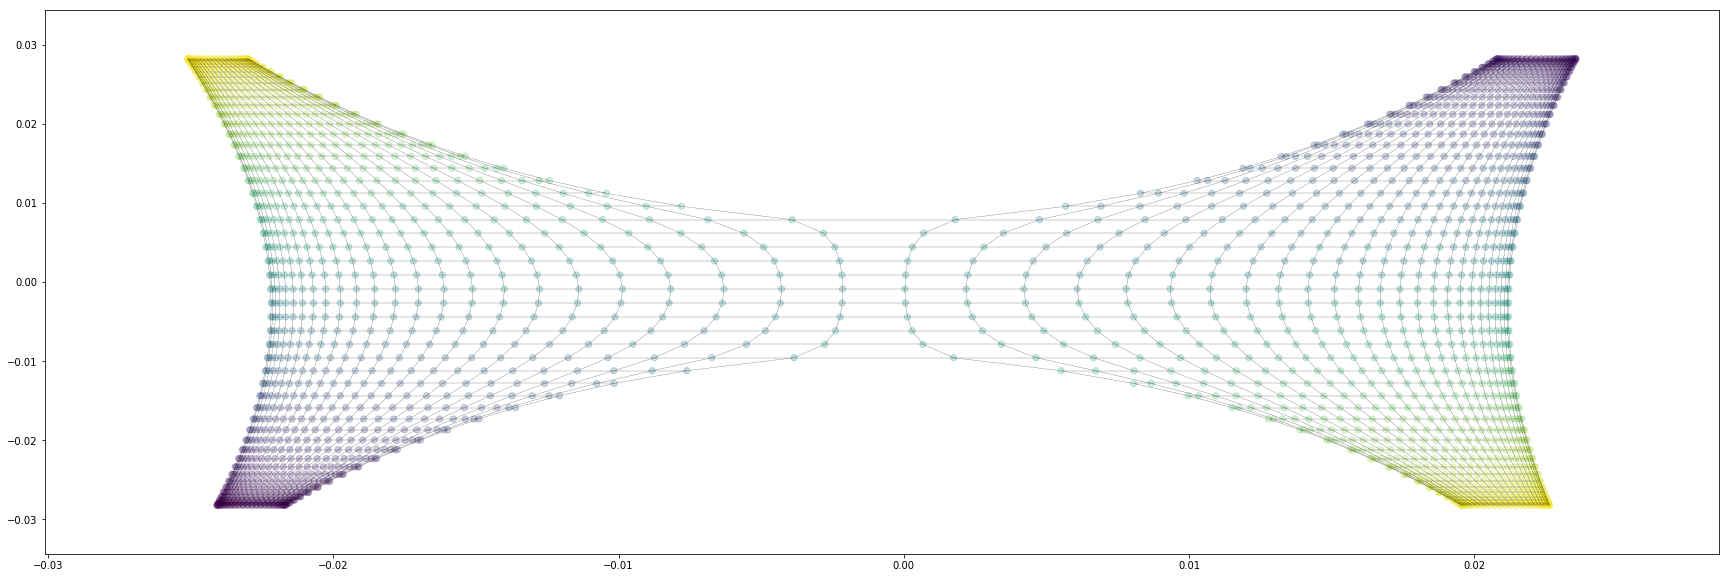

In [7]:
plot_graph(vectors[:, [1, 2]], adj,
           edges = 1,
           colors=vectors[:, 3])

### strong clusters, weakly connected

Now let's build some strongly connected clusters and connect them weakly. This graph will have a diameter of the same order as how many clusters. Its first few eigenvectors neatly capture the structure of the clusters 

In [8]:
how_many_clusters = 4
mean_cluster_size = 25

p = 0.75  # intracluster connection probability
q = 0.15  # additional connection probability

cluster_sizes = np.random.poisson(
    mean_cluster_size, how_many_clusters
)

adj = 0 + la.block_diag(*[np.random.random((m, m)) <= p
                          for m in cluster_sizes])

adj += np.random.random(adj.shape) <= q
adj[adj > 1] = 1  # redundant edges

In [9]:
adj = np.asmatrix(adj)
lap = compute_undirected_laplacian(adj)

m = 10
values, vectors = la.eigh(lap, eigvals=(0, m))

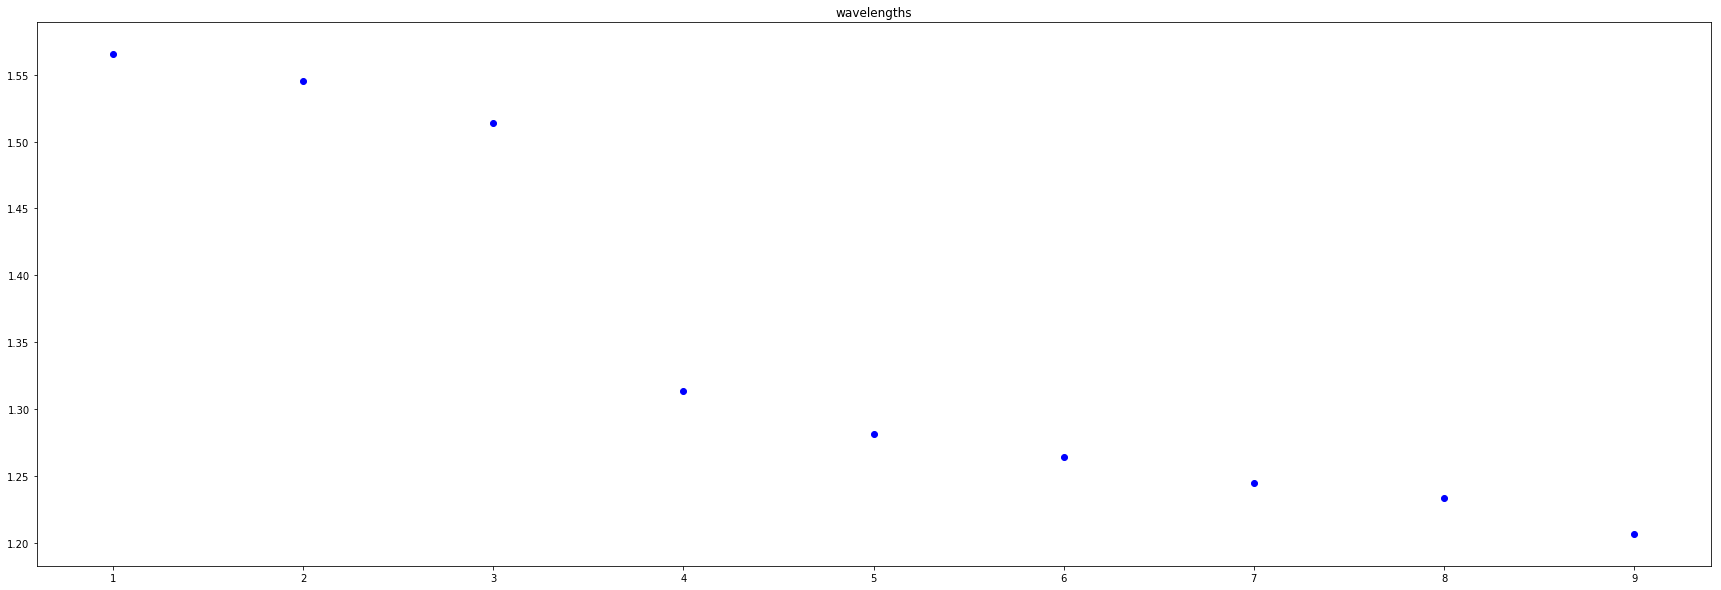

In [10]:
wavelengths = 2 * np.pi * np.reciprocal(np.sqrt(values[1:m]))

plt.scatter(range(1, m), wavelengths, color = 'blue')
plt.title('wavelengths')
plt.show()

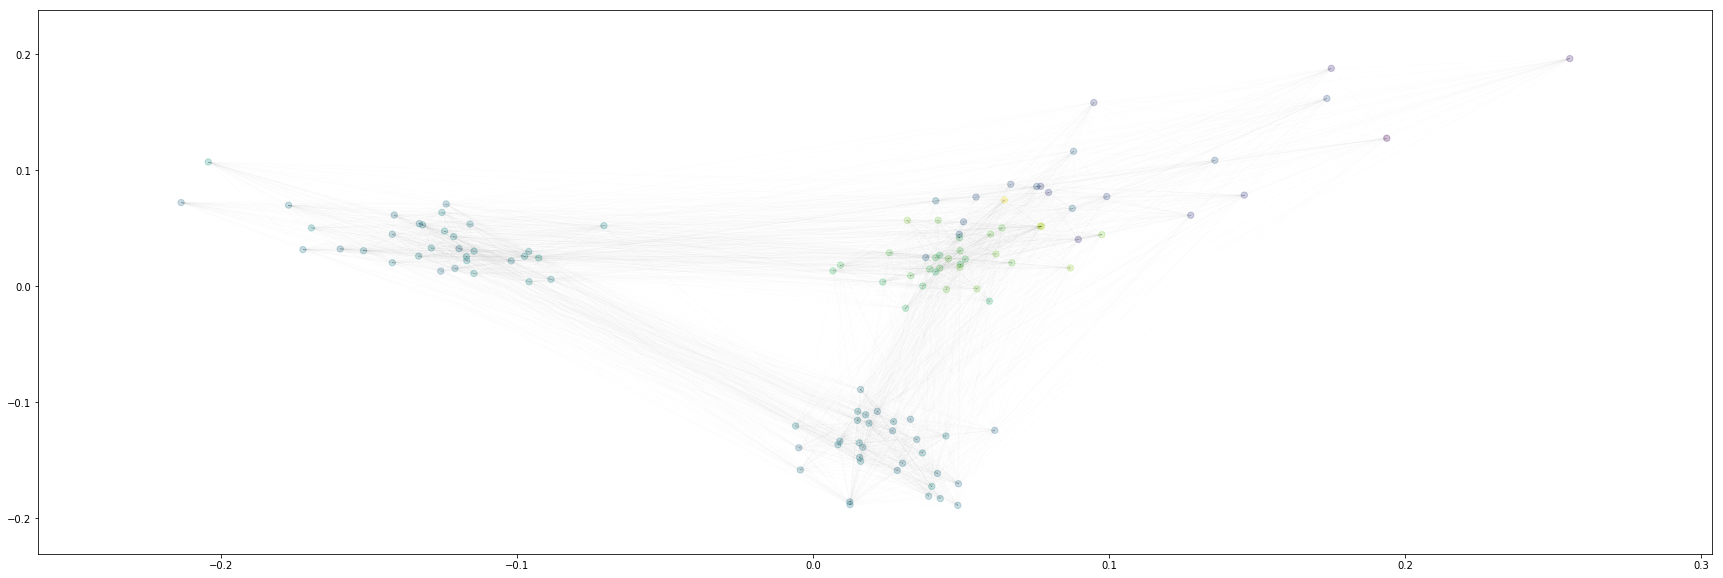

In [11]:
plot_graph(vectors[:, [1, 2]], adj,
           edges = 0.05,
           colors=vectors[:, 3])

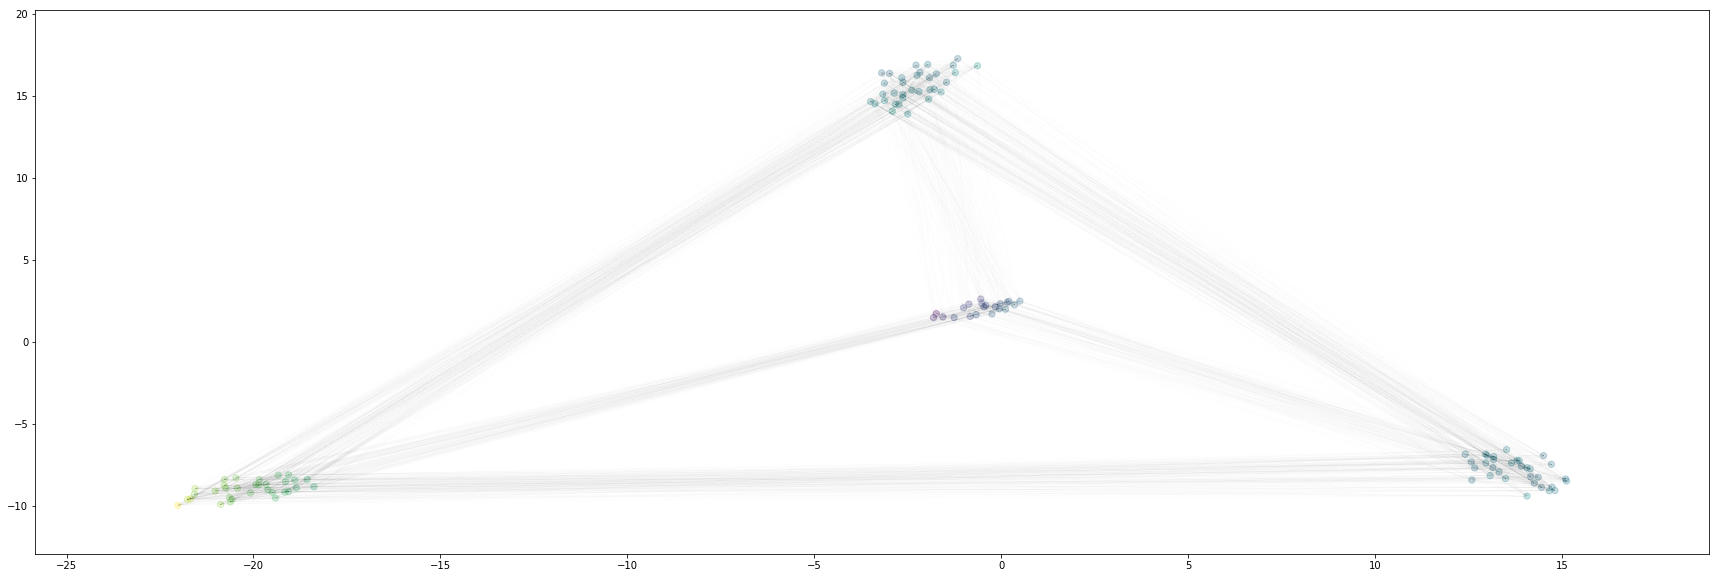

In [12]:
tsne_coords = TSNE(
    perplexity=mean_cluster_size
).fit_transform(
    vectors[:, 1:how_many_clusters]
)

plot_graph(tsne_coords, adj,
           edges = 0.05,
           colors=vectors[:, 3])

### biclusters

 

In [13]:
how_many_clusters_a = 5
how_many_clusters_b = 3
cluster_size = 50

probs = np.random.random((how_many_clusters_a, how_many_clusters_b))

probs[probs < 0.5] = 0.05
probs[probs >= 0.5] = 0.5

n = cluster_size * (how_many_clusters_a + how_many_clusters_b)
adj = np.zeros((n, n))

for a in range(how_many_clusters_a):
    for i in range(cluster_size):     
        for b in range(how_many_clusters_b):
            for j in range(cluster_size):
                x = cluster_size * a + i
                y = cluster_size * (b + how_many_clusters_a) + j
                p = probs[a, b]
                if np.random.random() <= p:
                    adj[x, y] = 1
                    adj[y, x] = 1


In [14]:
adj = np.asmatrix(adj)
lap = compute_undirected_laplacian(adj)

m = 10
values, vectors = la.eigh(lap, eigvals=(0, m))

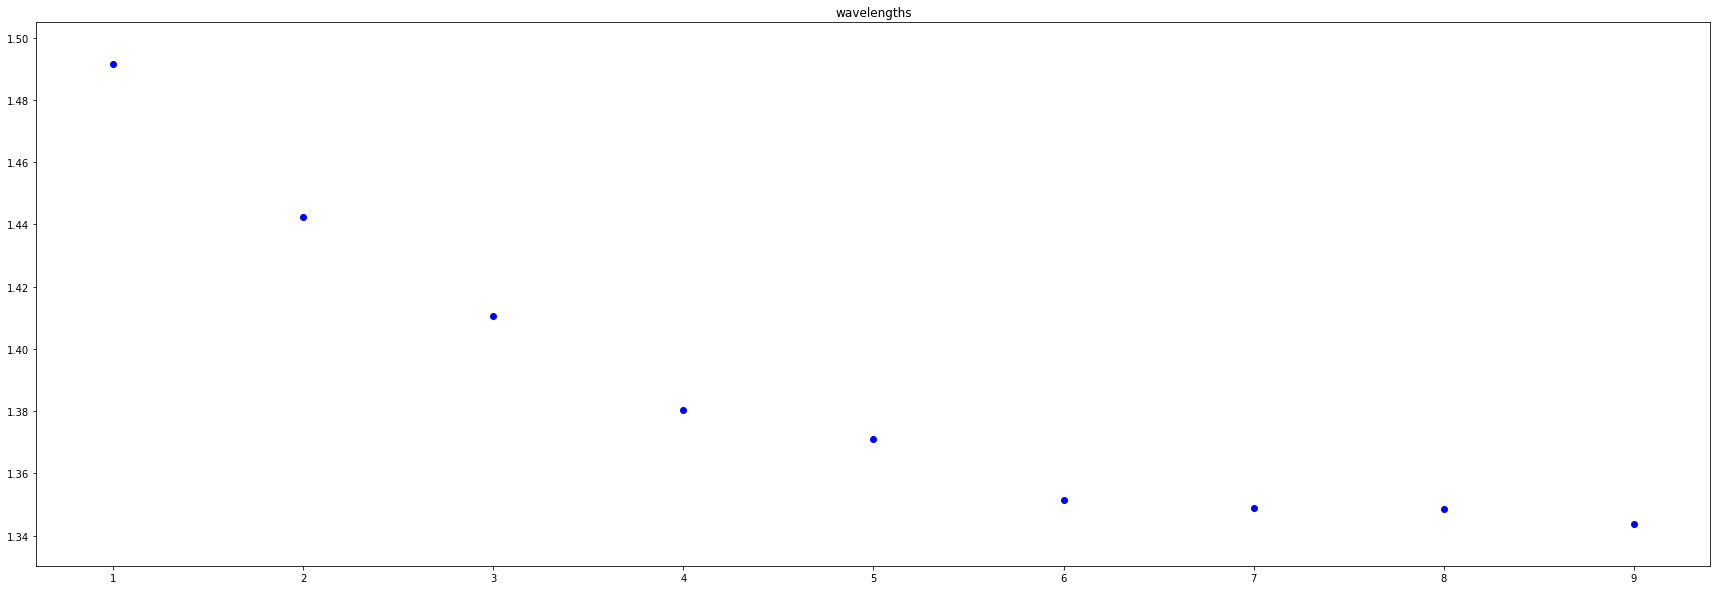

In [15]:
wavelengths = 2 * np.pi * np.reciprocal(np.sqrt(values[1:m]))

plt.scatter(range(1, m), wavelengths, color = 'blue')
plt.title('wavelengths')
plt.show()

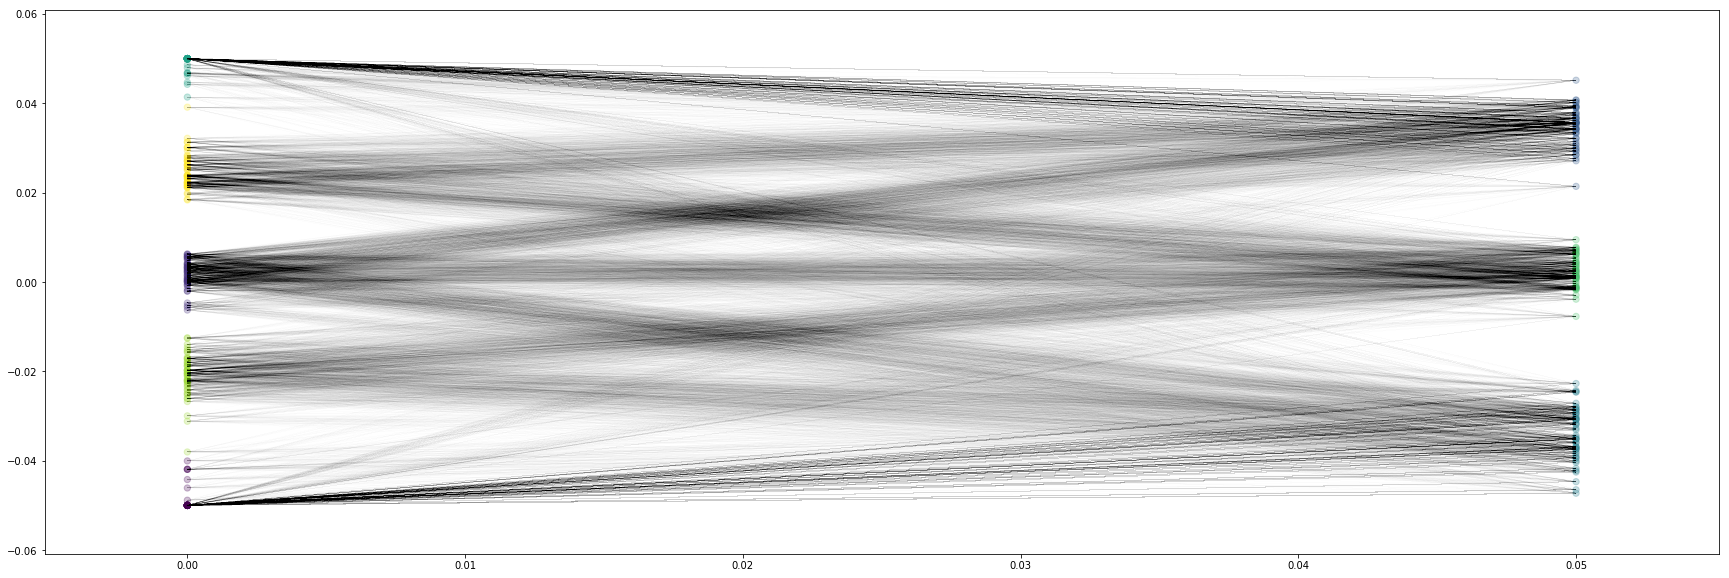

In [16]:
# whether it's of type b
indicator_b = np.array(range(vectors.shape[0])) >= cluster_size * how_many_clusters_a

coords = np.copy(vectors[:, 0:3])
coords[:, 0] = indicator_b

epsilon = 0.05
coords[coords > epsilon] = epsilon
coords[coords < -epsilon] = -epsilon

clusters = KMeans(8).fit_predict(coords)

plot_graph(coords, adj, edges = 0.05, colors=clusters)